In [125]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
if mp.get_start_method(allow_none=True) != 'fork':
    mp.set_start_method('fork', force=True)

In [384]:
# get the data from last 60 days until the present
dataF = yf.download("^NDX", period="730d", interval='1h')


# dataF = yf.download("^NDX", start="2023-10-25", end="2023-12-21", interval='15m')
# dataF = yf.download("EURJPY=X", period="60d", interval='15m')
# dataF = yf.download("^SPX", period="500d", interval='1h')
# dataF = yf.download("AAPL", period="730d", interval='1h')
# dataF = yf.download("^NDX", period="50d", interval='5m')
# dataF = yf.download("EURUSD=x", period="50d", interval='5m')
# dataF = yf.download("EURJPY=X", period="50d", interval='30m') # <-- this is the one
# dataF = yf.download("EURJPY=X", period="365d", interval='1h')# <-- this is the one
# dataF = yf.download("EURJPY=X", period="500d", interval='1h')# <--------- this is the one
# dataF = yf.download("EURUSD=X", period="365d", interval='1h') # XXXX Horrible
# dataF = yf.download("USDJPY=X", period="365d", interval='1h') <-- not too bad

# dataF.iloc[:,:]
#dataF.Open.iloc

[*********************100%%**********************]  1 of 1 completed


In [385]:
df = pd.DataFrame(dataF)

# use df index, convert DateTime to  a column instead of index
df.reset_index(inplace=True)

# delete Adj Close
df = df.drop(['Adj Close'], axis=1)

# rename Datetime to "Gmt time"
df = df.rename(columns={'Datetime':'Gmt time'})

# set gmt time as index
# df.set_index('Gmt time', inplace=True)

df=df[df.High!=df.Low]
df.reset_index(inplace=True)
df.head()

df

,index,Gmt time,Open,High,Low,Close,Volume
0,0,2021-06-16 09:30:00-04:00,14055.517578,14100.028320,14052.151367,14088.312500,0
1,1,2021-06-16 10:30:00-04:00,14089.168945,14089.168945,14052.279297,14060.084961,52545172
2,2,2021-06-16 11:30:00-04:00,14059.788086,14060.919922,13985.717773,13999.781250,45009970
3,3,2021-06-16 12:30:00-04:00,13999.793945,14036.599609,13999.793945,14023.344727,36663880
4,4,2021-06-16 13:30:00-04:00,14023.203125,14044.946289,13870.929688,13932.000977,77006686
...,...,...,...,...,...,...,...
5082,5082,2024-05-09 11:30:00-04:00,18129.984375,18135.615234,18076.724609,18100.087891,71023812
5083,5083,2024-05-09 12:30:00-04:00,18100.070312,18131.443359,18086.927734,18121.960938,59800388
5084,5084,2024-05-09 13:30:00-04:00,18122.046875,18124.583984,18095.775391,18117.648438,51704425
5085,5085,2024-05-09 14:30:00-04:00,18117.767578,18137.863281,18111.406250,18112.318359,59258966


In [386]:
import pandas_ta as ta
df["MACD"]=ta.macd(df.Close)['MACD_12_26_9']
df["MACD_HIST"]=ta.macd(df.Close)['MACDh_12_26_9']
df["MACD_SIGNAL"]=ta.macd(df.Close)['MACDs_12_26_9']
df["ADX"]=ta.adx(df.High, df.Low, df.Close)['ADX_14']
df["20_MA"] = ta.ema(df.Close, length=20)
df["50_MA"] = ta.ema(df.Close, length=50)
df["100_MA"] = ta.ema(df.Close, length=100)
df["200_MA"]= ta.ema(df.Close, length=200)
df['EMA']=ta.ema(df.Close, length=200)#sma ema
df['EMA2']=ta.ema(df.Close, length=150)#sma ema
df['EMA3']=ta.ema(df.Close, length=100)#sma ema
df['EMA4']=ta.ema(df.Close, length=50)#sma ema
df['EMA5']=ta.ema(df.Close, length=20)#sma ema
df['RSI']=ta.rsi(df.Close, length=12)

# df["HA_OPEN"]=ta.ha(df.Open, df.High, df.Low, df.Close)['HA_open']
# df["HA_CLOSE"]=ta.ha(df.Open, df.High, df.Low, df.Close)['HA_close']
my_bbands = ta.bbands(df.Close, length=14, std=2.0)
df=df.join(my_bbands)

In [387]:
def addemasignal(df):
    emasignal = [0]*len(df)
    for i in range(0, len(df)):
        if df.EMA3[i]>df.EMA[i]:
            emasignal[i]=2
        elif df.EMA3[i]<df.EMA[i]:
            emasignal[i]=1
        if (df.EMA4[i]<df.EMA2[i]):
            emasignal[i]=0
    df['EMASignal'] = emasignal
addemasignal(df)

In [388]:
def addorderslimit(df, percent):
    ordersignal=[0]*len(df)
    for i in range(1, len(df)): #EMASignal of previous candle!!! modified!!!
        if  df.Close[i]<=df['BBL_14_2.0'][i] and df.EMASignal[i]==2:
            ordersignal[i]=df.Close[i]-df.Close[i]*percent
        elif df.Close[i]>=df['BBU_14_2.0'][i] and df.EMASignal[i]==1:
            ordersignal[i]=df.Close[i]+df.Close[i]*percent
    df['ordersignal']=ordersignal
    
addorderslimit(df, 0.000)

In [389]:
df['index_entry'] = df.index
# # copy gmt time into a enw column
df['Date'] = df['Gmt time']

# # copy the index to a new col

# # set it as the index
df.set_index('Date', inplace=True)



In [390]:
df[df.ordersignal!=0]

,index,Gmt time,Open,High,Low,Close,Volume,MACD,MACD_HIST,MACD_SIGNAL,...,EMA5,RSI,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0,EMASignal,ordersignal,index_entry
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-27 12:30:00-04:00,199,2021-07-27 12:30:00-04:00,14864.399414,14868.166016,14787.804688,14805.257812,66099402,11.102699,-44.878880,55.981579,...,14988.462171,27.418378,14829.081774,15050.693708,15272.305642,2.944873,-0.053752,2,14805.257812,199
2021-07-30 09:30:00-04:00,217,2021-07-30 09:30:00-04:00,14884.983398,14990.443359,14884.983398,14952.042969,0,14.660789,-6.544920,21.205709,...,15023.226486,40.496328,14963.531132,15037.108747,15110.686362,0.978614,-0.078068,2,14952.042969,217
2021-08-03 10:30:00-04:00,232,2021-08-03 10:30:00-04:00,14945.449219,14945.449219,14864.853516,14900.640625,86268732,-14.328832,-9.355522,-4.973310,...,14981.996371,35.279175,14904.951609,14975.821150,15046.690690,0.946453,-0.030415,2,14900.640625,232
2021-08-10 10:30:00-04:00,267,2021-08-10 10:30:00-04:00,15106.607422,15106.607422,15010.455078,15044.187500,100345563,6.342191,-9.263500,15.605691,...,15110.373554,34.287048,15066.510814,15113.900600,15161.290386,0.627102,-0.235529,2,15044.187500,267
2021-08-16 09:30:00-04:00,294,2021-08-16 09:30:00-04:00,15091.497070,15115.882812,14952.518555,14952.518555,0,1.990714,-3.502621,5.493335,...,15079.035508,28.253010,14993.852119,15086.784040,15179.715961,1.231965,-0.222386,2,14952.518555,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02 10:30:00-04:00,4892,2024-04-02 10:30:00-04:00,18033.537109,18065.726562,18008.232422,18062.503906,99394892,-28.680917,-20.658747,-8.022170,...,18226.183860,32.646494,18077.496498,18235.177037,18392.857575,1.729411,-0.047541,2,18062.503906,4892
2024-04-04 14:30:00-04:00,4910,2024-04-04 14:30:00-04:00,18134.990234,18134.990234,17915.033203,17915.785156,138974744,-13.788648,-11.456728,-2.331921,...,18190.432452,31.214617,17987.381755,18201.625698,18415.869640,2.354119,-0.167091,2,17915.785156,4910
2024-04-04 15:30:00-04:00,4911,2024-04-04 15:30:00-04:00,17916.007812,17943.119141,17875.886719,17876.177734,109509573,-37.128450,-27.837223,-9.291227,...,18160.503431,29.624269,17913.306075,18183.878069,18454.450064,2.975955,-0.068611,2,17876.177734,4911


## Visualization

In [391]:
import numpy as np
def pointposbreak(x):
    if x['ordersignal']!=0:
        return x['ordersignal']
    else:
        return np.nan
df['pointposbreak'] = df.apply(lambda row: pointposbreak(row), axis=1)

In [392]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

dfpl = df[1000:].copy()
#dfpl=dfpl.drop(columns=['level_0'])#!!!!!!!!!!
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                go.Scatter(x=dfpl.index, y=dfpl.EMA, line=dict(color='orange', width=2), name="EMA"),
                go.Scatter(x=dfpl.index, y=dfpl.EMA2, line=dict(color='yellow', width=2), name="EMA2"),        
                go.Scatter(x=dfpl.index, y=dfpl['BBL_14_2.0'], line=dict(color='blue', width=1), name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_14_2.0'], line=dict(color='blue', width=1), name="BBU")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=6, color="MediumPurple"),
                name="Signal")
#fig.update(layout_yaxis_range = [300,420])
fig.update_xaxes(rangeslider_visible=False)
fig.update_layout(autosize=False, width=1000, height=600,margin=dict(l=50,r=50,b=100,t=100,pad=4), paper_bgcolor="white")
fig.show()

In [393]:
df

,index,Gmt time,Open,High,Low,Close,Volume,MACD,MACD_HIST,MACD_SIGNAL,...,RSI,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0,EMASignal,ordersignal,index_entry,pointposbreak
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-16 09:30:00-04:00,0,2021-06-16 09:30:00-04:00,14055.517578,14100.028320,14052.151367,14088.312500,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN
2021-06-16 10:30:00-04:00,1,2021-06-16 10:30:00-04:00,14089.168945,14089.168945,14052.279297,14060.084961,52545172,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,NaN
2021-06-16 11:30:00-04:00,2,2021-06-16 11:30:00-04:00,14059.788086,14060.919922,13985.717773,13999.781250,45009970,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,2,NaN
2021-06-16 12:30:00-04:00,3,2021-06-16 12:30:00-04:00,13999.793945,14036.599609,13999.793945,14023.344727,36663880,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,NaN
2021-06-16 13:30:00-04:00,4,2021-06-16 13:30:00-04:00,14023.203125,14044.946289,13870.929688,13932.000977,77006686,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-09 11:30:00-04:00,5082,2024-05-09 11:30:00-04:00,18129.984375,18135.615234,18076.724609,18100.087891,71023812,65.232645,-17.008703,82.241348,...,60.245077,18038.432695,18089.013253,18139.593812,0.559241,0.609475,1,0.0,5082,NaN
2024-05-09 12:30:00-04:00,5083,2024-05-09 12:30:00-04:00,18100.070312,18131.443359,18086.927734,18121.960938,59800388,63.604163,-14.909748,78.513911,...,62.736980,18043.728980,18087.216657,18130.704334,0.480866,0.899473,2,0.0,5083,NaN
2024-05-09 13:30:00-04:00,5084,2024-05-09 13:30:00-04:00,18122.046875,18124.583984,18095.775391,18117.648438,51704425,61.259435,-13.803580,75.063016,...,61.902422,18044.075154,18089.971680,18135.868205,0.507425,0.801513,2,0.0,5084,NaN


In [394]:
dfpl = df[:].copy()
def SIGNAL():
    return dfpl.ordersignal

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/backtesting.py:1539: UserWarning:

Searching for best of 304 configurations.



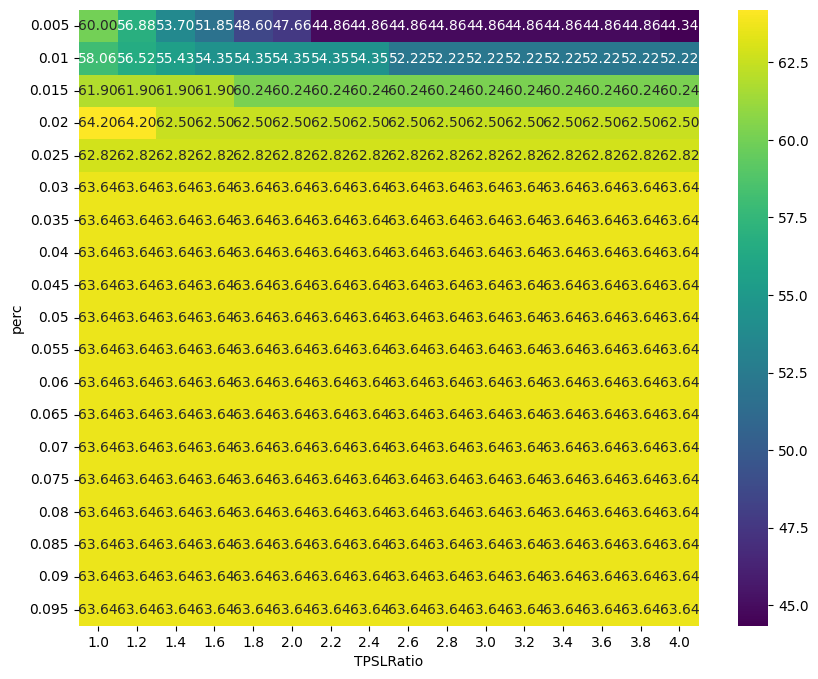

In [395]:
from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    initsize = 0.03
    mysize = initsize
    risk = 0
    latestEntry = 0
    perc = 0.02
    TPSLRatio = 2
    
    def init(self):
        super().init()
        self.signal = self.I(SIGNAL)

    def next(self):
        super().next()
        TPSLRatio = self.TPSLRatio
        perc = self.perc
        lastEntryIndex = 0
        
        if len(self.trades)>0:
            
            # close the position if the amount lost exceeds 3% of the account balance
            # if (self.position.pl < -1 * self.equity * 0.03):
            #     self.position.close()
                # print("Close position due to loss")
                # print("------")
            
            # if the pl is greater than the stop loss amount, then move the stop loss to entry
            if (self.position.pl > self.risk):
                # adjust the stop loss to entry
                self.position.sl = self.latestEntry
        
            if self.data['index_entry'][-1]-self.lastEntryIndex>=16:
                self.trades[-1].close()
                self.lastEntryIndex = self.data['index_entry'][-1]
            if self.trades[-1].is_long and self.data.RSI[-1]>=90:
                self.trades[-1].close()
                self.lastEntryIndex = self.data['index_entry'][-1]
            elif self.trades[-1].is_short and self.data.RSI[-1]<=10:
                self.trades[-1].close()
                self.lastEntryIndex = self.data['index_entry'][-1]
        
        if self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==2:  
            sl1 = min(self.data.Low[-1],self.data.Low[-2])*(1-perc)
            tp1 = self.data.Close[-1]+(self.data.Close[-1] - sl1)*TPSLRatio
            entry = self.data.Close[-1]
            self.risk = entry - sl1
            self.latestEntry = entry
            self.lastEntryIndex = self.data['index_entry'][-1]
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==1:         
            sl1 = sl1 = max(self.data.High[-1],self.data.High[-2])*(1+perc)
            tp1 = self.data.Close[-1]-(sl1 - self.data.Close[-1])*TPSLRatio
            entry = self.data.Close[-1]
            self.risk = sl1 - entry
            self.latestEntry = entry
            self.lastEntryIndex = self.data['index_entry'][-1]
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfpl, MyStrat, cash=100000, margin=1/100)
stat, heatmap = bt.optimize(perc=[float(i)/1000 for i in range(5, 100, 5)],
                        TPSLRatio=[float(i/10) for i in range(10, 41, 2)],
                        maximize='Win Rate [%]', max_tries=400,
                            random_state=0,
                            return_heatmap=True)

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.2f')
plt.show()

In [396]:
bt.plot()
stat

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_94480/1321969246.py:1: UserWarning:

Superimposed OHLC plot matches the original plot. Skipping.



Start                     2021-06-16 09:30...
End                       2024-05-09 15:30...
Duration                   1058 days 06:00:00
Exposure Time [%]                    22.84254
Equity Final [$]                376777.375449
Equity Peak [$]                 376777.375449
Return [%]                         276.777375
Buy & Hold Return [%]               28.570848
Return (Ann.) [%]                   58.175942
Volatility (Ann.) [%]               42.443789
Sharpe Ratio                         1.370659
Sortino Ratio                          3.8784
Calmar Ratio                         2.310242
Max. Drawdown [%]                  -25.181754
Avg. Drawdown [%]                   -2.704691
Max. Drawdown Duration      335 days 00:00:00
Avg. Drawdown Duration       12 days 12:00:00
# Trades                                   81
Win Rate [%]                        64.197531
Best Trade [%]                       4.924135
Worst Trade [%]                     -2.867679
Avg. Trade [%]                    